# Working with noise

In this workbook, we can work with noise and how to handle one specific kind of noise - attribute noise. 

The workbook shows how to use random forest classifier in order to find which attributes contribute the most to the classifier. By doing this, we can see that the rest of the attributes are more or less just a noise. 

First, we start by extracting the BoW from the gerrit reviews.

Then, we use NTLK for sentiment classification of the review comments and finally, we use RandomForest classifier to find the most important attributes. 

In [2]:
# importing the libraries to vectorize text
# and to manipulate dataframes
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

In [3]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [4]:
# create the feature extractor, i.e., BOW vectorizer
# please note the argument - max_features
# this argument says that we only want three features
# this will illustrate that we can get problems - e.g. noise
# when using too few features
vectorizer = CountVectorizer()

In [1]:
# access google drive with code
# we import the library that helps us to connect to Google Drive
from google.colab import drive

# we connect to the google drive
drive.mount('/content/gdrive/')

# and we enter the folder where I stored the data
%cd '/content/gdrive/My Drive/ds/'

Mounted at /content/gdrive/
/content/gdrive/My Drive/ds


In [5]:
# read the file with gerrit code reviews
dfReviews = pd.read_csv('./gerrit_reviews.csv', sep=';')

# just checking that we have the right columns
# and the right data
dfReviews.head()

,change_id,revision-id,filename,line,start_line,end_line,LOC,message
0,cps~master~Ia67db468ece4a7ab694d95cb63a954f24d...,eee4b4538e74468dd70ffef68164ad9353d70616,cps-ncmp-service/src/test/groovy/org/onap/cps/...,259.0,249,259,def dmiServiceName = 'some service name',a lof of (brittle) code just for a stricter ch...
1,cps~master~Ia67db468ece4a7ab694d95cb63a954f24d...,eee4b4538e74468dd70ffef68164ad9353d70616,cps-ncmp-service/src/test/groovy/org/onap/cps/...,259.0,249,259,def compositeState = new CompositeStat...,a lof of (brittle) code just for a stricter ch...
2,cps~master~Ia67db468ece4a7ab694d95cb63a954f24d...,eee4b4538e74468dd70ffef68164ad9353d70616,cps-ncmp-service/src/test/groovy/org/onap/cps/...,259.0,249,259,lockReason: CompositeState.Loc...,a lof of (brittle) code just for a stricter ch...
3,cps~master~Ia67db468ece4a7ab694d95cb63a954f24d...,eee4b4538e74468dd70ffef68164ad9353d70616,cps-ncmp-service/src/test/groovy/org/onap/cps/...,259.0,249,259,"lastUpdateTime: 'some-timestamp',",a lof of (brittle) code just for a stricter ch...
4,cps~master~Ia67db468ece4a7ab694d95cb63a954f24d...,eee4b4538e74468dd70ffef68164ad9353d70616,cps-ncmp-service/src/test/groovy/org/onap/cps/...,259.0,249,259,"dataSyncEnabled: false,",a lof of (brittle) code just for a stricter ch...


In [6]:
import numpy as np
# before we use the feature extractor, let's check if the data contains NANs
print(f'The data contains {dfReviews.LOC.isnull().sum()} empty rows')

# remove the empty rows
dfReviews.dropna(inplace=True)

# checking again, to make sure that it does not contain them
print(f'The data contains {dfReviews.LOC.isnull().sum()} empty rows')

The data contains 218 empty rows
The data contains 0 empty rows


What we can see in the table above is that there is a lot of 0s in the feature vector. That is because we only use 20 features. 

Let's make this a bit more reliable - let's put constraints on the frequency of features, rather than on their number and see what happens.

In [7]:
# now, let's convert the code (LOC) column to the vector of features
# using BOW from the example above
vectorizer = CountVectorizer(min_df=2, 
                             max_df=10)

dfFeatures = vectorizer.fit_transform(dfReviews.LOC)

# creating the data frame based on the vectorized data
df_bow_sklearn = pd.DataFrame(dfFeatures.toarray(),
                              columns=vectorizer.get_feature_names(),
                              index=dfReviews.LOC)

# take a peek at the featurized data
df_bow_sklearn.head()

,11,2017,2019,2020,2021,2022,204,2c,2f,400,...,xpathsdescendant,yangcontainername,yangcontainername_,yangmodelcmhandle,yangresourcenametocontent,yangresourcesnametocontentmap,yangtextschemasourceset,yangtextschemasourcesetbuilder,yangtextschemasourcesetcache,yangutils
LOC,,,,,,,,,,,,,,,,,,,,,
def dmiServiceName = 'some service name',0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"def compositeState = new CompositeState(cmHandleState: CmHandleState.ADVISED,",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"lockReason: CompositeState.LockReason.builder().lockReasonCategory(LockReasonCategory.LOCKED_MODULE_SYNC_FAILED).details(""lock details"").build(),",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"lastUpdateTime: 'some-timestamp',",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"dataSyncEnabled: false,",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# we can also check how many features we actually have
# which is a lot in this case
len(df_bow_sklearn.columns)

662

## Sentiment analysis for the review comments.

In order to be able to use the classifier, we need to have something to predict. To create that data, we use sentiment analysis for the review comments and then we try to predict which lines of code are reviewed positively and which are reviewed negatively. 


In [9]:
dfReviewComments = dfReviews['message']
dfReviewComments.head()

0    a lof of (brittle) code just for a stricter ch...
1    a lof of (brittle) code just for a stricter ch...
2    a lof of (brittle) code just for a stricter ch...
3    a lof of (brittle) code just for a stricter ch...
4    a lof of (brittle) code just for a stricter ch...
Name: message, dtype: object

In [10]:
# for this example, we use a pre-trained senitment analysis model from 
# huggingface
! pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 63.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 91.2 MB/s eta 0:00:00


In [11]:
# using a classifier from Huggingface hus is quite straightforward
# we import the package and create the sentiment analysis piplie
from transformers import pipeline

# when we create the pipeline, and do not provide the model
# then the huggingface hub will choose one for us
# and download it
sentiment_pipeline = pipeline("sentiment-analysis")



No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [12]:
# now we are ready to get the sentiment from our reviews. 
# let's supply it to the sentiment analysis pipeline
lstSentiments = sentiment_pipeline(list(dfReviewComments))

In [13]:
# transform the list to a dataframe
dfSentiments = pd.DataFrame(lstSentiments)

# and then we change the textual value of the sentiment to 
# a numeric one - which we will use for the random forest
dfSentiment = dfSentiments.label.map({'NEGATIVE': 0, 'POSITIVE': 1})

In [14]:
df_bow_sklearn['sentiment']= list(dfSentiment)

In [15]:
# now, we train the RandomForest classifier to get the most important features
# Note! This training does not use any data split, as we only want to find
# which features are important.
X = df_bow_sklearn.drop(['sentiment'], axis=1)
Y = df_bow_sklearn['sentiment']



In [16]:
# import the classifier - Random Forest
from sklearn.ensemble import RandomForestClassifier

# create the classifier
clf = RandomForestClassifier(max_depth=10, random_state=42)

# train the classifier
# please note that we do not check how good the classifier is
# only train it to find the features that are important. 
clf.fit(X,Y)

RandomForestClassifier(max_depth=10, random_state=42)

In [20]:
# now, let's check which of the features are the most important ones
# first we create a dataframe from this list
# then we sort it descending
# and then filter the ones that are not imporatnt
dfImportantFeatures = pd.DataFrame(clf.feature_importances_, index=X.columns, columns=['importance'])

# sorting values according to their importance
dfImportantFeatures.sort_values(by=['importance'], 
                                ascending=False, 
                                inplace=True)

# choosing only the ones that are important, skipping
# the features which have importance of 0
dfOnlyImportant = dfImportantFeatures[dfImportantFeatures['importance'] != 0]

# print the results
print(f'All features: {dfImportantFeatures.shape[0]}, but only {dfOnlyImportant.shape[0]} are used in predictions. ')

All features: 662, but only 363 are used in predictions. 


## We plot the feature importance

Although the diagram is quite large, we can still see whether it's a handful of features that are the most important ones or all of them are. 

Text(0, 0.5, 'Feature names')

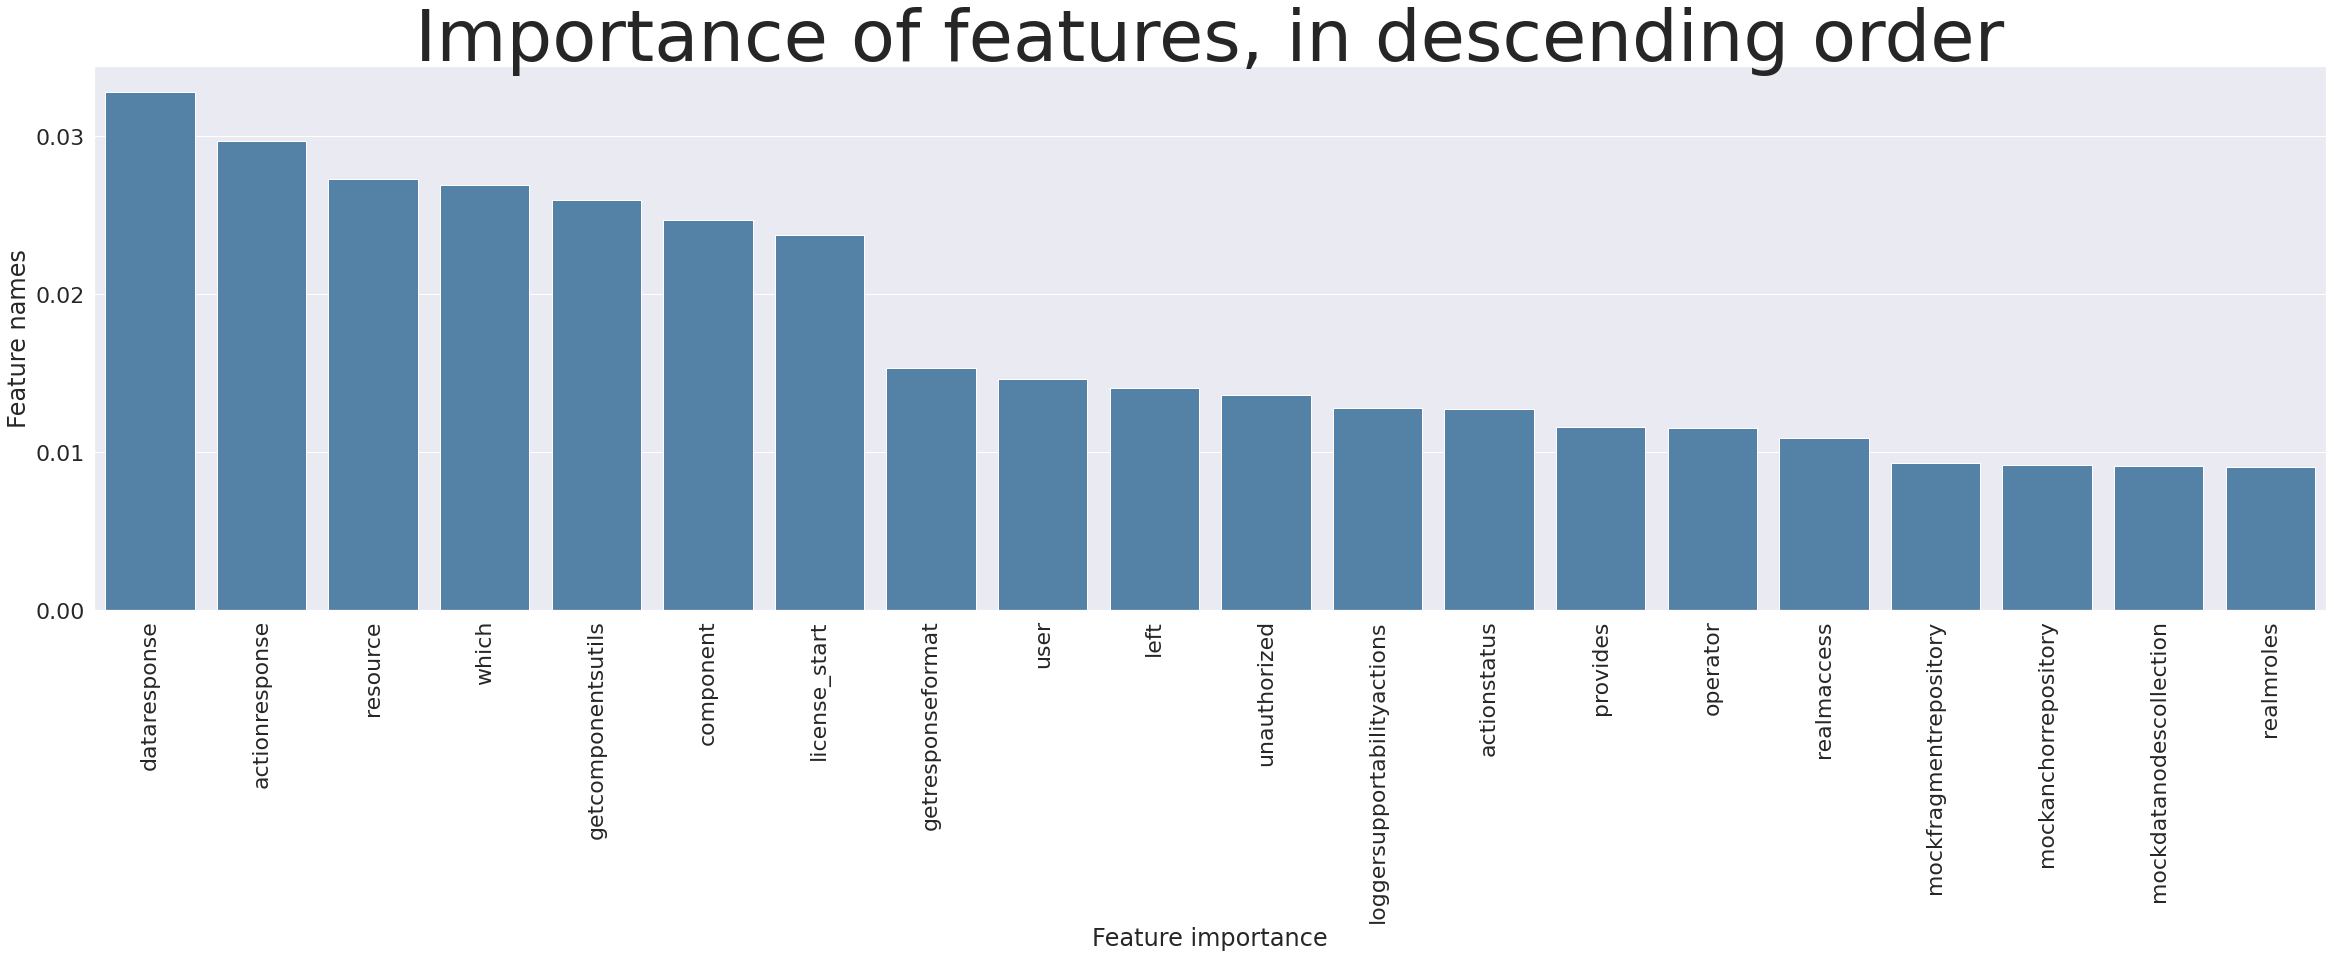

In [36]:
# we use matplotlib and seaborn to make the plot
import matplotlib.pyplot as plt
import seaborn as sns

# Define size of bar plot
# We make the x axis quite much larger than the y-axis since
# there is a lot of features to visualize
plt.figure(figsize=(40,10))

# plot Searborn bar chart
# we just use the blue color
sns.barplot(y=dfOnlyImportant['importance'][:20], 
            x=dfOnlyImportant.index[:20], 
            color='steelblue')

# we make the x-labels rotated so that we can fit
# all the features
plt.xticks(rotation=90)

sns.set(font_scale=6)

# add chart labels
plt.title('Importance of features, in descending order')
plt.xlabel('Feature importance')
plt.ylabel('Feature names')